# GAN

This notebook demonstrates the use of a GAN trained on the MNIST dataset.

## Install and Import packages

In [1]:
# %pip install numpy torch torchvision torch-summary Pillow ipython seaborn imageio

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from IPython.display import Video, display
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms
from typing import Any, List, Optional, Union

Set fixed seed for reproducibility

In [3]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

In [4]:
def pt_to_numpy(images: torch.FloatTensor) -> np.ndarray:
    return images.detach().cpu().permute(0, 2, 3, 1).float().numpy()


def numpy_to_pt(images: np.ndarray) -> torch.FloatTensor:
    if images.ndim == 3:
        images = images[..., None]
    return torch.from_numpy(images.transpose(0, 3, 1, 2))


def numpy_to_pil(images: np.ndarray) -> Image.Image:
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def pil_to_numpy(images: Union[List[Image.Image], Image.Image]) -> np.ndarray:
    if not isinstance(images, Image.Image) and not isinstance(images, list):
        raise ValueError(
            f"Expected PIL image or list of PIL images, got {type(images)}."
        )
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)
    return images


def normalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return 2.0 * images - 1.0


def denormalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return (0.5 + images / 2).clamp(0, 1)


def pil_to_video(images: List[Image.Image], filename: str, fps: int = 60) -> None:
    frames = [np.array(image) for image in images]
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames:
            video_writer.append_data(frame)


def image_grid(images: List[Image.Image], rows: int, cols: int) -> Image.Image:
    if len(images) > rows * cols:
        raise ValueError(
            f"Number of images ({len(images)}) exceeds grid size ({rows}x{cols})."
        )
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

### Load Dataset

Here, we load the MNIST dataset. We use a fixed subset of the dataset to speed up the training process since this is a simple demo. We convert the images to tensors and normalize values to the range [-1, 1].

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
subset_size = 20000

In [6]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
    ),
    download=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

#### Visualize training dataset

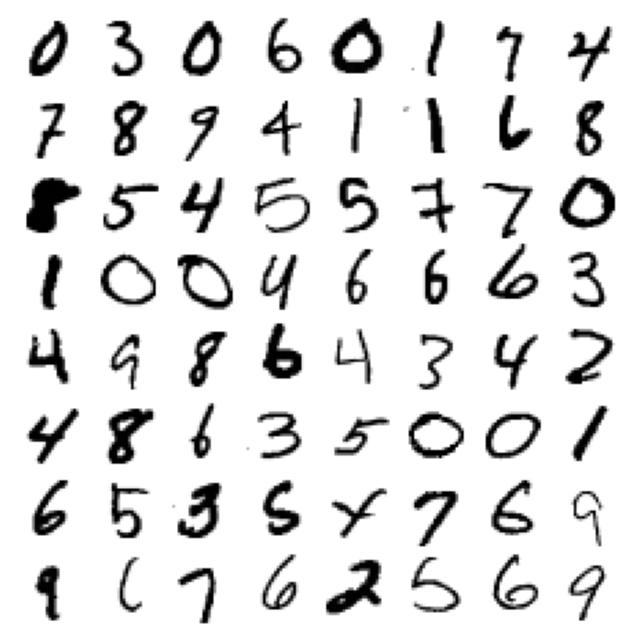

In [7]:
for batch_images, batch_labels in dataloader:
    rows = int(batch_size**0.5)
    if rows * rows < batch_size:
        rows += 1
    cols = rows
    batch_images = numpy_to_pil(pt_to_numpy(denormalize(batch_images)))
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image_grid(batch_images, rows=rows, cols=cols), cmap="binary")
    plt.axis("off")
    plt.show()
    break

## Creating Models

We define the Generator and Discriminator - components of a GAN.

In [8]:
class Generator(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.25, inplace=True),
                nn.Dropout(dropout),
            )

        self.model = nn.Sequential()

        self.model.append(block(latent_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Tanh())

    def forward(self, latent: torch.FloatTensor) -> torch.FloatTensor:
        latent = latent.to(self.device)

        latent = latent.view(-1, self.latent_dim)
        x = self.model(latent)

        return x.view(-1, 28, 28)

In [9]:
class Discriminator(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.25, inplace=True),
                nn.Dropout(dropout),
            )

        self.model = nn.Sequential()

        self.model.append(block(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Sigmoid())

        self.to(device)

    def forward(self, images: torch.FloatTensor) -> torch.FloatTensor:
        images = images.to(self.device)

        images = images.view(-1, 28 * 28)
        x = self.model(images)

        return x.squeeze()

#### Configure Hyperparameters for Training

In [10]:
epochs = 100
learning_rate_g = 1e-4
learning_rate_d = 3e-4
steps_g = 2
steps_d = 3
latent_dim = 128
embedding_dim = 10
dropout = 0.4
log_steps = 100

generator_hidden_dims = [256, 512, 1024]
discriminator_hidden_dims = [1024, 512, 256]

In [11]:
generator = Generator(
    latent_dim=latent_dim,
    output_dim=28 * 28,
    hidden_dims=generator_hidden_dims,
    dropout=dropout,
    device=device,
)
discriminator = Discriminator(
    input_dim=28 * 28,
    output_dim=1,
    hidden_dims=discriminator_hidden_dims,
    dropout=dropout,
    device=device,
)

In [12]:
_ = summary(
    generator,
    [(1, latent_dim)],
    dtypes=[torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Sequential: 2-1                   [-1, 256]                 --
|    |    └─Linear: 3-1                  [-1, 256]                 33,024
|    |    └─LeakyReLU: 3-2               [-1, 256]                 --
|    |    └─Dropout: 3-3                 [-1, 256]                 --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 131,584
|    |    └─LeakyReLU: 3-5               [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 1024]                --
|    |    └─Linear: 3-7                  [-1, 1024]                525,312
|    |    └─LeakyReLU: 3-8               [-1, 1024]                --
|    |    └─Dropout: 3-9                 [-1, 1024]                --
|

In [13]:
_ = summary(
    discriminator,
    [(1, 28, 28)],
    dtypes=[torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 1024]                --
|    |    └─Linear: 3-1                  [-1, 1024]                803,840
|    |    └─LeakyReLU: 3-2               [-1, 1024]                --
|    |    └─Dropout: 3-3                 [-1, 1024]                --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 524,800
|    |    └─LeakyReLU: 3-5               [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 256]                 --
|    |    └─Linear: 3-7                  [-1, 256]                 131,328
|    |    └─LeakyReLU: 3-8               [-1, 256]                 --
|    |    └─Dropout: 3-9                 [-1, 256]                 --


## Training

In [14]:
loss = nn.BCELoss()
optim_g = torch.optim.AdamW(generator.parameters(), lr=learning_rate_g)
optim_d = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_d)

In [15]:
def trainstep_g():
    optim_g.zero_grad()

    latent = torch.randn((batch_size, latent_dim))
    fake_images = generator(latent)

    validity = discriminator(fake_images)
    fake_loss = loss(validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optim_g.step()

    return fake_loss

In [16]:
def trainstep_d(images, labels):
    optim_d.zero_grad()

    # We can't use the global batch_size because dataloader may have truncation
    # for last uncomplete batch
    batch_size = images.shape[0]

    real_validity = discriminator(images)
    real_loss = loss(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_dim))
    fake_images = generator(latent)

    fake_validity = discriminator(fake_images)
    fake_loss = loss(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss.backward()
    optim_d.step()

    return discriminator_loss

In [17]:
grid_images = []
generator_losses = []
discriminator_losses = []

In [18]:
def train(epochs: int):
    steps = 0
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        generator.train()

        for index, (images, labels) in enumerate(dataloader):
            generator_loss = 0
            discriminator_loss = 0

            for _ in range(steps_g):
                generator_loss += trainstep_g().mean().item()
            for _ in range(steps_d):
                discriminator_loss += trainstep_d(images, labels).mean().item()

            generator_losses.append(generator_loss / steps_g)
            discriminator_losses.append(discriminator_loss / steps_d)

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
                )
            steps += 1

        print(
            f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
        )
        print("-" * 64)

        grid_image = visualize()
        grid_images.append(grid_image)

        if epoch % 8 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(grid_image, cmap="binary")
            plt.axis("off")
            plt.show()


def visualize():
    with torch.no_grad():
        generator.eval()

        gen = torch.Generator(device="cpu").manual_seed(420)
        latents = torch.randn((100, latent_dim), generator=gen)
        sampled_images = generator(latents).unsqueeze(dim=1)
        sampled_images = numpy_to_pil(pt_to_numpy(denormalize(sampled_images)))
        grid_image = image_grid(sampled_images, rows=10, cols=10)

    return grid_image

Epoch: 0, Generator loss: 1.4031, Discriminator loss: 1.7949
Epoch: 0, Generator loss: 11.5740, Discriminator loss: 0.1749
Epoch: 0, Generator loss: 17.6371, Discriminator loss: 0.2330
Epoch: 0, Generator loss: 8.2769, Discriminator loss: 0.3018
Epoch: 0, Generator loss: 4.8621, Discriminator loss: 0.7412
----------------------------------------------------------------


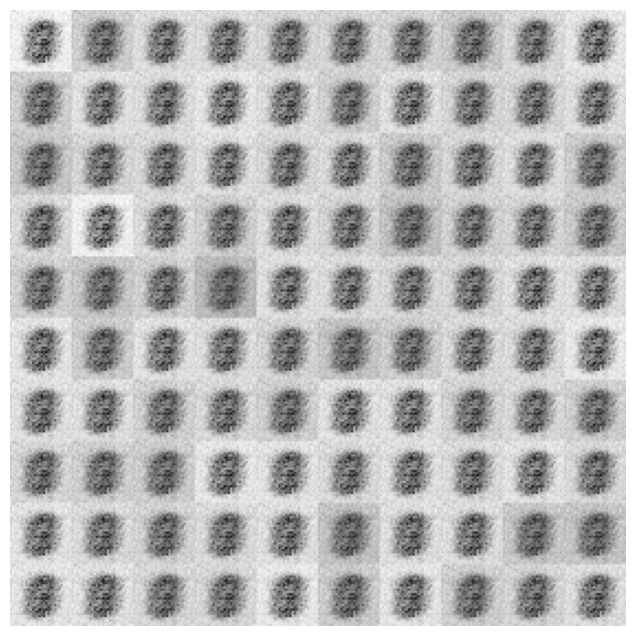

Epoch: 1, Generator loss: 15.1812, Discriminator loss: 0.0332
Epoch: 1, Generator loss: 14.2802, Discriminator loss: 0.0145
Epoch: 1, Generator loss: 16.6815, Discriminator loss: 0.0116
Epoch: 1, Generator loss: 19.5795, Discriminator loss: 0.0826
----------------------------------------------------------------
Epoch: 2, Generator loss: 22.8292, Discriminator loss: 0.0278
Epoch: 2, Generator loss: 16.2180, Discriminator loss: 0.1127
Epoch: 2, Generator loss: 21.2585, Discriminator loss: 0.0519
Epoch: 2, Generator loss: 18.6252, Discriminator loss: 0.1793
----------------------------------------------------------------
Epoch: 3, Generator loss: 14.2878, Discriminator loss: 0.1243
Epoch: 3, Generator loss: 20.9899, Discriminator loss: 0.2270
Epoch: 3, Generator loss: 9.8349, Discriminator loss: 0.2836
Epoch: 3, Generator loss: 12.5013, Discriminator loss: 0.1817
----------------------------------------------------------------
Epoch: 4, Generator loss: 12.8877, Discriminator loss: 0.1886


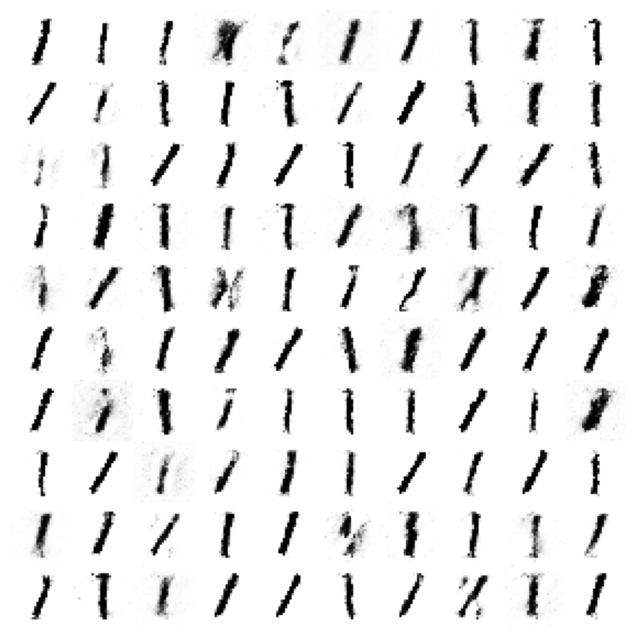

Epoch: 9, Generator loss: 5.2647, Discriminator loss: 0.3368
Epoch: 9, Generator loss: 6.1457, Discriminator loss: 0.4770
Epoch: 9, Generator loss: 5.1962, Discriminator loss: 0.6776
Epoch: 9, Generator loss: 4.3921, Discriminator loss: 0.5255
----------------------------------------------------------------
Epoch: 10, Generator loss: 5.2791, Discriminator loss: 0.7388
Epoch: 10, Generator loss: 6.7944, Discriminator loss: 0.7933
Epoch: 10, Generator loss: 5.9195, Discriminator loss: 0.4243
Epoch: 10, Generator loss: 3.4960, Discriminator loss: 0.5831
----------------------------------------------------------------
Epoch: 11, Generator loss: 5.2753, Discriminator loss: 0.3862
Epoch: 11, Generator loss: 5.1100, Discriminator loss: 0.6877
Epoch: 11, Generator loss: 6.1096, Discriminator loss: 0.7500
Epoch: 11, Generator loss: 5.7003, Discriminator loss: 0.3862
----------------------------------------------------------------
Epoch: 12, Generator loss: 4.5064, Discriminator loss: 0.6935
Epo

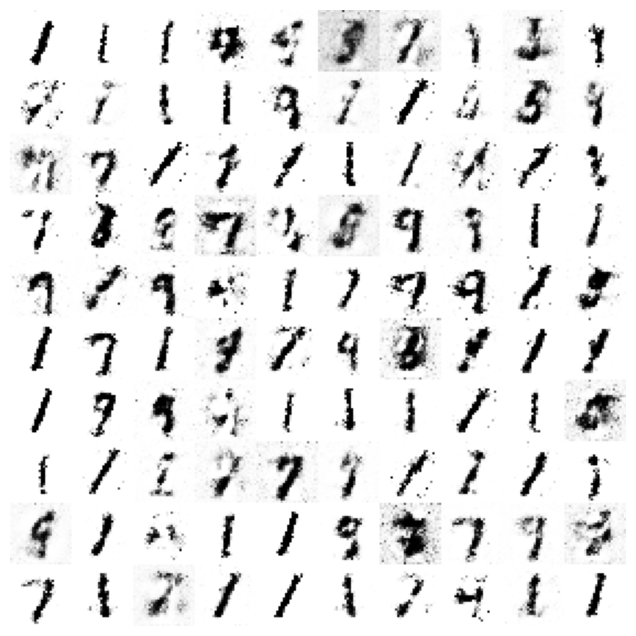

Epoch: 17, Generator loss: 5.1861, Discriminator loss: 0.8909
Epoch: 17, Generator loss: 7.3819, Discriminator loss: 0.6714
Epoch: 17, Generator loss: 5.0782, Discriminator loss: 0.8364
Epoch: 17, Generator loss: 3.5278, Discriminator loss: 1.0005
----------------------------------------------------------------
Epoch: 18, Generator loss: 4.1759, Discriminator loss: 0.9134
Epoch: 18, Generator loss: 4.8856, Discriminator loss: 0.9079
Epoch: 18, Generator loss: 4.4572, Discriminator loss: 1.0094
Epoch: 18, Generator loss: 3.9211, Discriminator loss: 1.0105
----------------------------------------------------------------
Epoch: 19, Generator loss: 4.8205, Discriminator loss: 0.9756
Epoch: 19, Generator loss: 4.9251, Discriminator loss: 1.1041
Epoch: 19, Generator loss: 4.1874, Discriminator loss: 0.9206
Epoch: 19, Generator loss: 5.0129, Discriminator loss: 0.9470
----------------------------------------------------------------
Epoch: 20, Generator loss: 5.4642, Discriminator loss: 0.8388

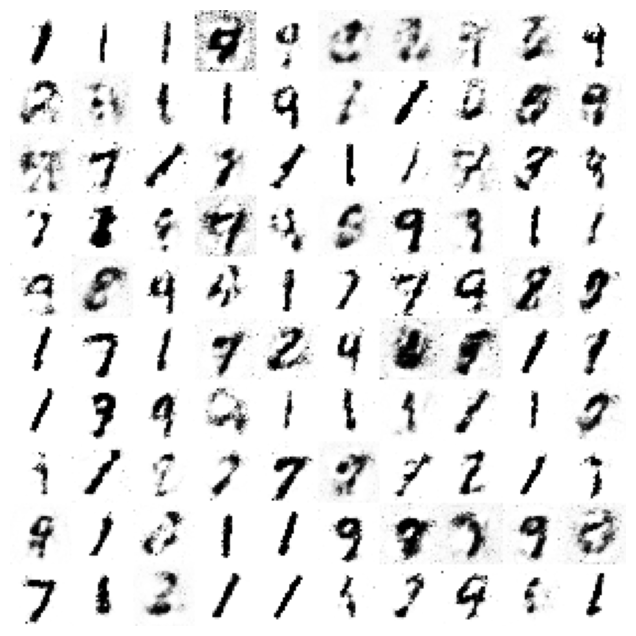

Epoch: 25, Generator loss: 3.9276, Discriminator loss: 0.9312
Epoch: 25, Generator loss: 3.0852, Discriminator loss: 1.0754
Epoch: 25, Generator loss: 3.5138, Discriminator loss: 1.1204
Epoch: 25, Generator loss: 4.2730, Discriminator loss: 1.1499
----------------------------------------------------------------
Epoch: 26, Generator loss: 5.6585, Discriminator loss: 0.7647
Epoch: 26, Generator loss: 3.8936, Discriminator loss: 1.0220
Epoch: 26, Generator loss: 4.2364, Discriminator loss: 1.1880
Epoch: 26, Generator loss: 3.6761, Discriminator loss: 1.2080
----------------------------------------------------------------
Epoch: 27, Generator loss: 3.3503, Discriminator loss: 1.1059
Epoch: 27, Generator loss: 4.0742, Discriminator loss: 1.1377
Epoch: 27, Generator loss: 4.8683, Discriminator loss: 1.0164
Epoch: 27, Generator loss: 3.8884, Discriminator loss: 0.9156
----------------------------------------------------------------
Epoch: 28, Generator loss: 3.9335, Discriminator loss: 1.1226

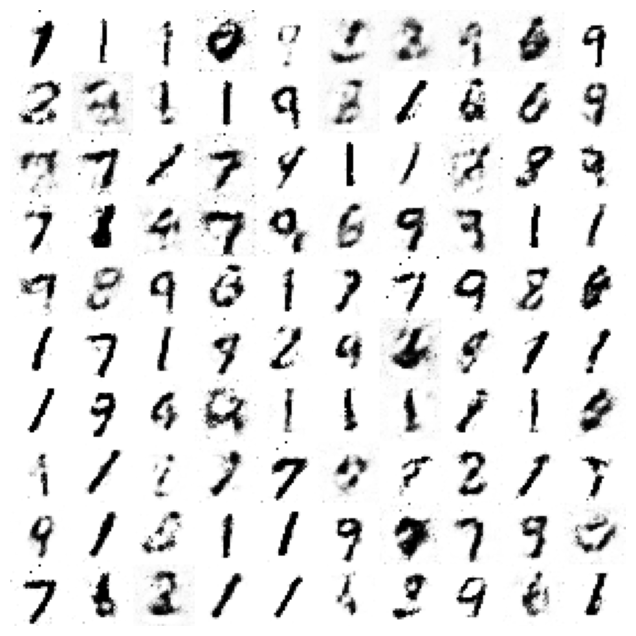

Epoch: 33, Generator loss: 3.2757, Discriminator loss: 1.0308
Epoch: 33, Generator loss: 4.6905, Discriminator loss: 1.1679
Epoch: 33, Generator loss: 4.4929, Discriminator loss: 1.3522
Epoch: 33, Generator loss: 3.6949, Discriminator loss: 1.0245
----------------------------------------------------------------
Epoch: 34, Generator loss: 4.3584, Discriminator loss: 1.0278
Epoch: 34, Generator loss: 3.9357, Discriminator loss: 1.3450
Epoch: 34, Generator loss: 4.1536, Discriminator loss: 0.9070
Epoch: 34, Generator loss: 4.0759, Discriminator loss: 0.9921
----------------------------------------------------------------
Epoch: 35, Generator loss: 3.3217, Discriminator loss: 1.2841
Epoch: 35, Generator loss: 3.4365, Discriminator loss: 0.9952
Epoch: 35, Generator loss: 3.8400, Discriminator loss: 1.0608
Epoch: 35, Generator loss: 4.4650, Discriminator loss: 1.2207
----------------------------------------------------------------
Epoch: 36, Generator loss: 5.6681, Discriminator loss: 0.9439

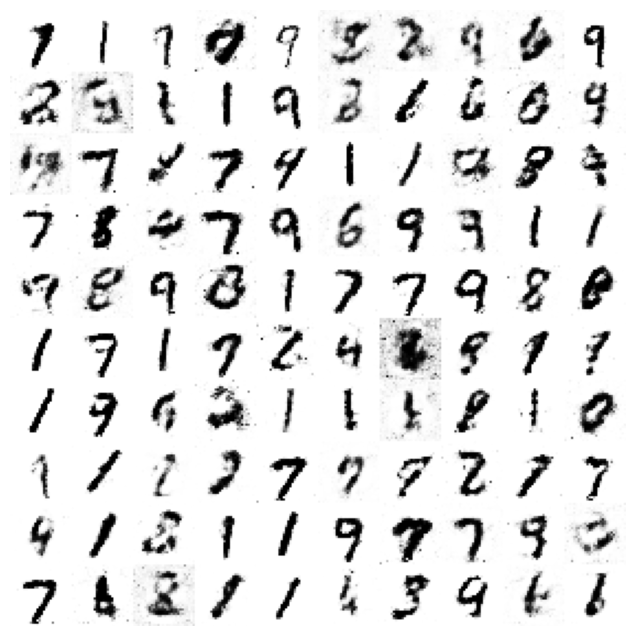

Epoch: 41, Generator loss: 2.9053, Discriminator loss: 1.3350
Epoch: 41, Generator loss: 4.1967, Discriminator loss: 1.5225
Epoch: 41, Generator loss: 3.4635, Discriminator loss: 1.0919
Epoch: 41, Generator loss: 3.4935, Discriminator loss: 1.6117
----------------------------------------------------------------
Epoch: 42, Generator loss: 3.3011, Discriminator loss: 1.0205
Epoch: 42, Generator loss: 3.1753, Discriminator loss: 1.3555
Epoch: 42, Generator loss: 4.3925, Discriminator loss: 1.1944
Epoch: 42, Generator loss: 2.5085, Discriminator loss: 1.0785
----------------------------------------------------------------
Epoch: 43, Generator loss: 4.8273, Discriminator loss: 1.1154
Epoch: 43, Generator loss: 3.0068, Discriminator loss: 1.1437
Epoch: 43, Generator loss: 3.5146, Discriminator loss: 1.1565
Epoch: 43, Generator loss: 4.0690, Discriminator loss: 0.8836
----------------------------------------------------------------
Epoch: 44, Generator loss: 4.0448, Discriminator loss: 1.3726

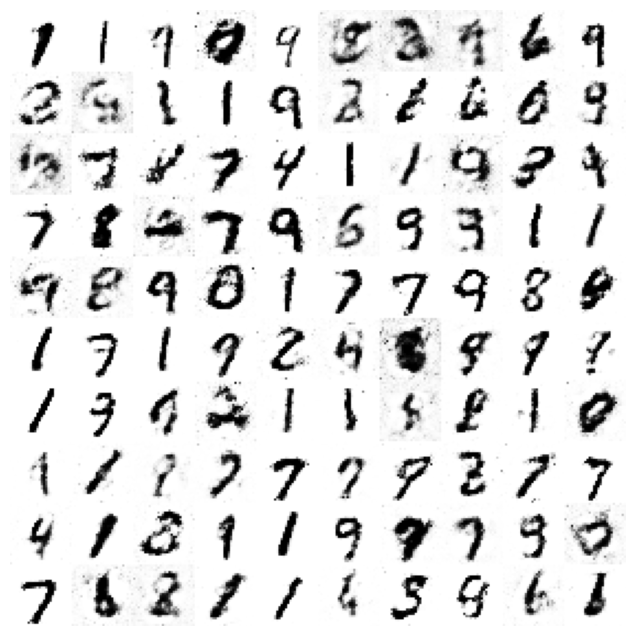

Epoch: 49, Generator loss: 4.1079, Discriminator loss: 1.1377
Epoch: 49, Generator loss: 3.8790, Discriminator loss: 1.3245
Epoch: 49, Generator loss: 3.0602, Discriminator loss: 1.4396
Epoch: 49, Generator loss: 3.7146, Discriminator loss: 1.1085
----------------------------------------------------------------
Epoch: 50, Generator loss: 4.0236, Discriminator loss: 1.1086
Epoch: 50, Generator loss: 3.0597, Discriminator loss: 1.1571
Epoch: 50, Generator loss: 3.0573, Discriminator loss: 1.1860
Epoch: 50, Generator loss: 3.1918, Discriminator loss: 1.1177
----------------------------------------------------------------
Epoch: 51, Generator loss: 2.6257, Discriminator loss: 1.4087
Epoch: 51, Generator loss: 4.8659, Discriminator loss: 1.1506
Epoch: 51, Generator loss: 2.9695, Discriminator loss: 1.1722
Epoch: 51, Generator loss: 3.9034, Discriminator loss: 1.0871
----------------------------------------------------------------
Epoch: 52, Generator loss: 3.9313, Discriminator loss: 1.4166

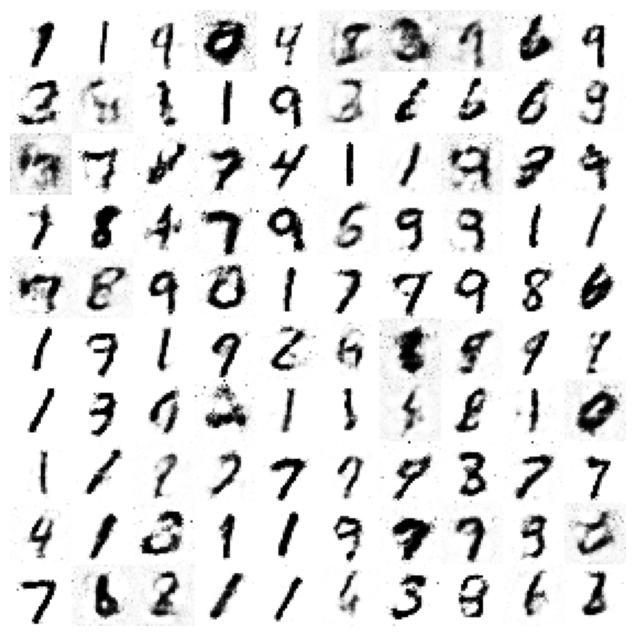

Epoch: 57, Generator loss: 4.7948, Discriminator loss: 1.2505
Epoch: 57, Generator loss: 3.0998, Discriminator loss: 1.2894
Epoch: 57, Generator loss: 2.9888, Discriminator loss: 1.4960
Epoch: 57, Generator loss: 3.2101, Discriminator loss: 1.2576
----------------------------------------------------------------
Epoch: 58, Generator loss: 3.7779, Discriminator loss: 0.9769
Epoch: 58, Generator loss: 3.3770, Discriminator loss: 1.3944
Epoch: 58, Generator loss: 3.0948, Discriminator loss: 1.2930
Epoch: 58, Generator loss: 2.1884, Discriminator loss: 1.3302
----------------------------------------------------------------
Epoch: 59, Generator loss: 2.8918, Discriminator loss: 1.3516
Epoch: 59, Generator loss: 2.9077, Discriminator loss: 1.4286
Epoch: 59, Generator loss: 2.2104, Discriminator loss: 1.3169
Epoch: 59, Generator loss: 4.0827, Discriminator loss: 1.2238
----------------------------------------------------------------
Epoch: 60, Generator loss: 3.0967, Discriminator loss: 1.2530

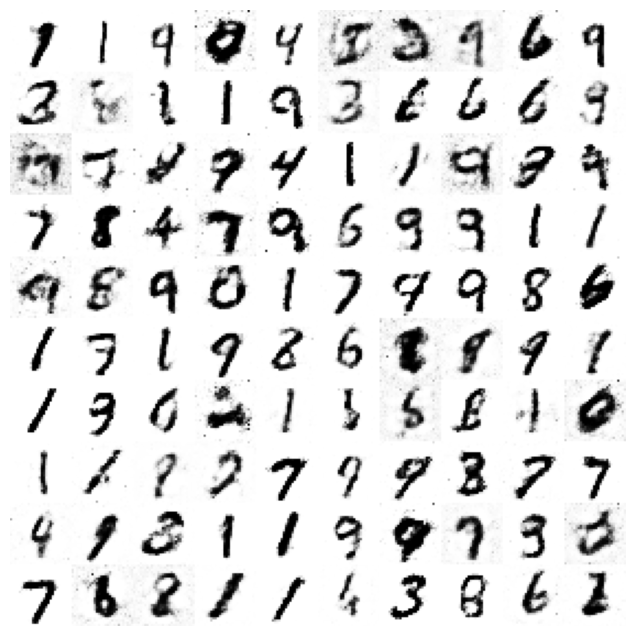

Epoch: 65, Generator loss: 3.0607, Discriminator loss: 1.3169
Epoch: 65, Generator loss: 3.2105, Discriminator loss: 1.3489
Epoch: 65, Generator loss: 4.7775, Discriminator loss: 1.2699
Epoch: 65, Generator loss: 2.8692, Discriminator loss: 1.3467
----------------------------------------------------------------
Epoch: 66, Generator loss: 4.7900, Discriminator loss: 1.4014
Epoch: 66, Generator loss: 4.4199, Discriminator loss: 1.0558
Epoch: 66, Generator loss: 3.7939, Discriminator loss: 1.3363
Epoch: 66, Generator loss: 2.5556, Discriminator loss: 1.2424
----------------------------------------------------------------
Epoch: 67, Generator loss: 2.9926, Discriminator loss: 1.2005
Epoch: 67, Generator loss: 2.9378, Discriminator loss: 1.3085
Epoch: 67, Generator loss: 2.9779, Discriminator loss: 1.5831
Epoch: 67, Generator loss: 4.0663, Discriminator loss: 1.2426
----------------------------------------------------------------
Epoch: 68, Generator loss: 4.8011, Discriminator loss: 1.2500

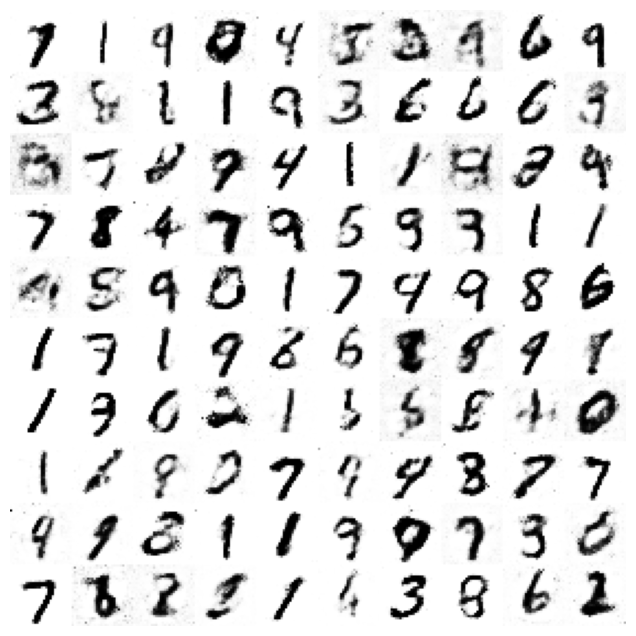

Epoch: 73, Generator loss: 2.9512, Discriminator loss: 1.2161
Epoch: 73, Generator loss: 3.1283, Discriminator loss: 1.5776
Epoch: 73, Generator loss: 3.0549, Discriminator loss: 1.3697
Epoch: 73, Generator loss: 3.0106, Discriminator loss: 1.3286
----------------------------------------------------------------
Epoch: 74, Generator loss: 3.8033, Discriminator loss: 1.1245
Epoch: 74, Generator loss: 3.3898, Discriminator loss: 1.3063
Epoch: 74, Generator loss: 3.3895, Discriminator loss: 1.3128
Epoch: 74, Generator loss: 3.6226, Discriminator loss: 1.3251
----------------------------------------------------------------
Epoch: 75, Generator loss: 3.0545, Discriminator loss: 1.3528
Epoch: 75, Generator loss: 3.5795, Discriminator loss: 1.1774
Epoch: 75, Generator loss: 3.2813, Discriminator loss: 1.4371
Epoch: 75, Generator loss: 3.7097, Discriminator loss: 1.3154
----------------------------------------------------------------
Epoch: 76, Generator loss: 2.8369, Discriminator loss: 1.2031

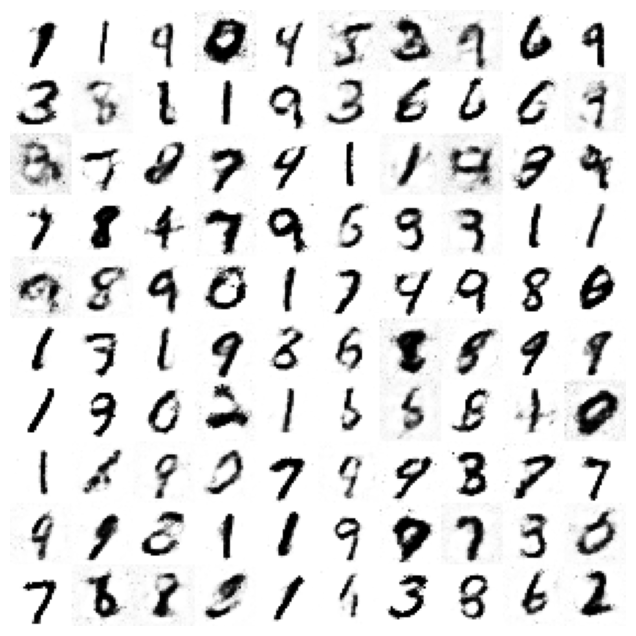

Epoch: 81, Generator loss: 3.4165, Discriminator loss: 1.4986
Epoch: 81, Generator loss: 2.8603, Discriminator loss: 1.3550
Epoch: 81, Generator loss: 2.7058, Discriminator loss: 1.2789
Epoch: 81, Generator loss: 2.8914, Discriminator loss: 1.6754
----------------------------------------------------------------
Epoch: 82, Generator loss: 2.9076, Discriminator loss: 1.4819
Epoch: 82, Generator loss: 3.8368, Discriminator loss: 1.2267
Epoch: 82, Generator loss: 3.2589, Discriminator loss: 1.1085
Epoch: 82, Generator loss: 4.0018, Discriminator loss: 1.0948
----------------------------------------------------------------
Epoch: 83, Generator loss: 2.9411, Discriminator loss: 1.3720
Epoch: 83, Generator loss: 2.9789, Discriminator loss: 1.3494
Epoch: 83, Generator loss: 2.9732, Discriminator loss: 1.3257
Epoch: 83, Generator loss: 4.0707, Discriminator loss: 1.1792
----------------------------------------------------------------
Epoch: 84, Generator loss: 2.6619, Discriminator loss: 1.2436

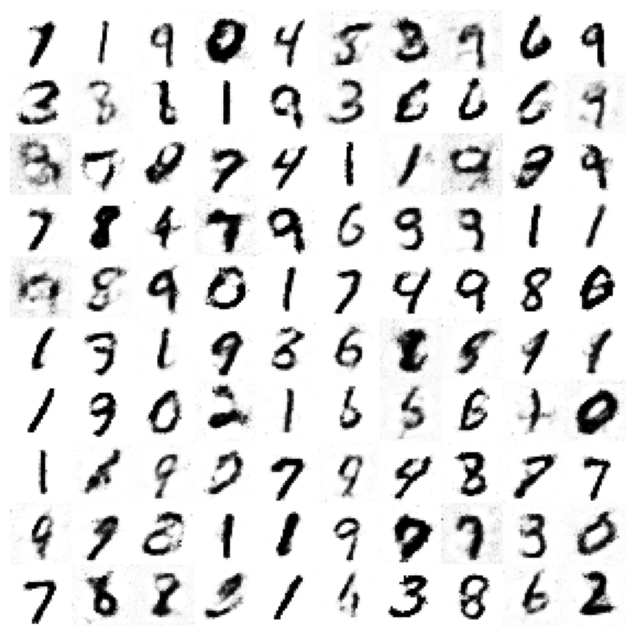

Epoch: 89, Generator loss: 3.0826, Discriminator loss: 1.5057
Epoch: 89, Generator loss: 2.6572, Discriminator loss: 1.5512
Epoch: 89, Generator loss: 3.0657, Discriminator loss: 1.2865
Epoch: 89, Generator loss: 2.7660, Discriminator loss: 1.3719
----------------------------------------------------------------
Epoch: 90, Generator loss: 3.9988, Discriminator loss: 1.2666
Epoch: 90, Generator loss: 3.3567, Discriminator loss: 1.3062
Epoch: 90, Generator loss: 2.3737, Discriminator loss: 1.3648
Epoch: 90, Generator loss: 3.3172, Discriminator loss: 1.3430
----------------------------------------------------------------
Epoch: 91, Generator loss: 3.5792, Discriminator loss: 1.3795
Epoch: 91, Generator loss: 3.2422, Discriminator loss: 1.4003
Epoch: 91, Generator loss: 2.6428, Discriminator loss: 1.4947
Epoch: 91, Generator loss: 2.6556, Discriminator loss: 1.7732
----------------------------------------------------------------
Epoch: 92, Generator loss: 2.5757, Discriminator loss: 1.4239

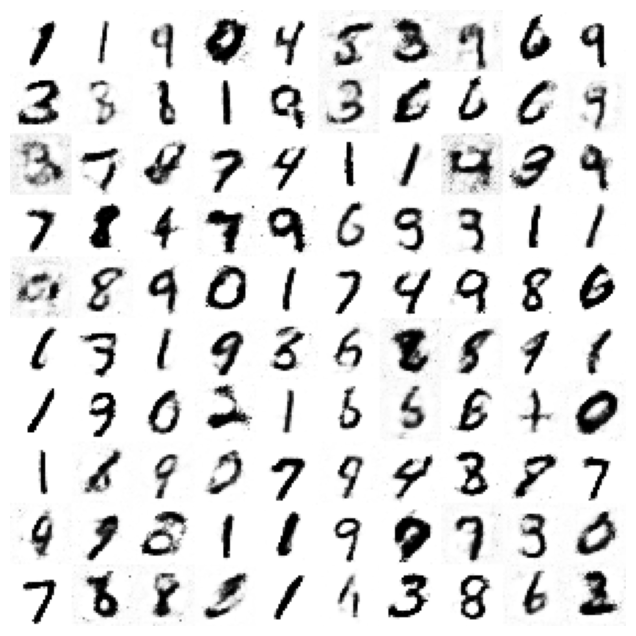

Epoch: 97, Generator loss: 2.9195, Discriminator loss: 1.3316
Epoch: 97, Generator loss: 3.1151, Discriminator loss: 1.4620
Epoch: 97, Generator loss: 2.9648, Discriminator loss: 1.4011
Epoch: 97, Generator loss: 3.1357, Discriminator loss: 1.2897
----------------------------------------------------------------
Epoch: 98, Generator loss: 3.3455, Discriminator loss: 1.3766
Epoch: 98, Generator loss: 2.5649, Discriminator loss: 1.3680
Epoch: 98, Generator loss: 3.0907, Discriminator loss: 1.3390
Epoch: 98, Generator loss: 2.8244, Discriminator loss: 1.5064
----------------------------------------------------------------
Epoch: 99, Generator loss: 2.8801, Discriminator loss: 1.4817
Epoch: 99, Generator loss: 2.4992, Discriminator loss: 1.3440
Epoch: 99, Generator loss: 3.5542, Discriminator loss: 1.2632
Epoch: 99, Generator loss: 3.7763, Discriminator loss: 1.4174
----------------------------------------------------------------


In [19]:
train(epochs)

## Visualization

In [20]:
filename = "gan_generation_over_time.mp4"
pil_to_video(grid_images, filename, fps=8)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (280, 280) to (288, 288) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7088180] Warning: data is not aligned! This can lead to a speed loss


In [21]:
display(Video(filename, embed=True))

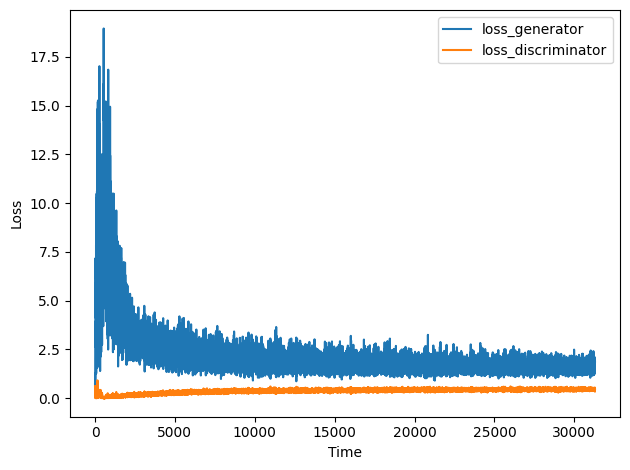

In [22]:
plt.plot(generator_losses, label="loss_generator")
plt.plot(discriminator_losses, label="loss_discriminator")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
plt.show()

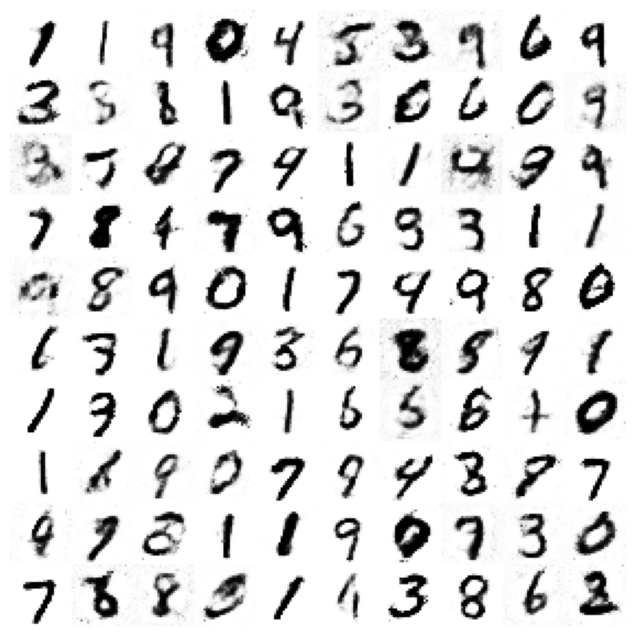

In [23]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(visualize(), cmap="binary")
plt.axis("off")
plt.show()